# Load packages and data

In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import collections
import itertools
import seaborn as sns

from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt

import toverboom
import toverboom.optimizeLayout
import toverboom.lineageGraph

import random

### Import scar data:

In [2]:
pathToData = '/Users/m.blotenburg/Documents/Projects/Mouse_Scartrace/Data_analysis/Scar_analysis/20200511_AllScarData_Remapped_MaskedRef_alteredAlleles/120hAA_VAN2988_SQ98/dataframes/'
df = pd.read_pickle(pathToData + '120hAA_dataframeForHeatmap_All_filtered.pickle.gz')


In [3]:
df.head()

129, 114682729 129, 114708745  \
C5A9 A2_1                                                   WT             WT   
     A2_10                                                  WT            NaN   
     A2_100                                                 WT            NaN   
     A2_101  114682780.D,114682781.D,114682782.D,114682783....            NaN   
     A2_102  114682783.D,114682784.D,114682785.D,114682786....            NaN   

            129, 114723869                                     129, 114788469  \
C5A9 A2_1               WT  114788523.D,114788524.D,114788525.D,114788526....   
     A2_10             NaN  114788523.D,114788524.D,114788525.D,114788526....   
     A2_100            NaN  114788523.D,114788524.D,114788525.D,114788526....   
     A2_101            NaN  114788523.D,114788524.D,114788525.D,114788526....   
     A2_102            NaN  114788523.D,114788524.D,114788525.D,114788526....   

            129, 114817194 129, 114879985 129, 114896335 129, 114875401  \
C5A9 A2_1               WT             WT             WT            NaN   
     A2_10              WT            NaN            NaN            NaN   
     A2_100             WT            NaN            NaN             WT   
     A2_101             WT            NaN            NaN            NaN   
     A2_102             WT            NaN            NaN            NaN   

            129, 114781506 129, 114829429  ... nonallelic, 114736342  \
C5A9 A2_1              NaN            NaN  ...                   NaN   
     A2_10             NaN            NaN  ...                   NaN   
     A2_100            NaN            NaN  ...                   NaN   
     A2_101            NaN            NaN  ...                   NaN   
     A2_102            NaN            NaN  ...                   NaN   

            nonallelic, 114513427 nonallelic, 115623258 nonallelic, 114851287  \
C5A9 A2_1                     NaN                   NaN                   NaN   
     A2_10                    NaN                   NaN                   NaN   
     A2_100                   NaN                   NaN                   NaN   
     A2_101                   NaN                   NaN                   NaN   
     A2_102                   NaN                   NaN                   NaN   

            nonallelic, 114896400 nonallelic, 114896394 nonallelic, 114817194  \
C5A9 A2_1                     NaN                   NaN                   NaN   
     A2_10                    NaN                   NaN                   NaN   
     A2_100                   NaN                   NaN                   NaN   
     A2_101                   NaN                   NaN                   NaN   
     A2_102                   NaN                   NaN                   NaN   

            nonallelic, 114896315 nonallelic, 114896317 nonallelic, 114682797  
C5A9 A2_1                     NaN                   NaN                   NaN  
     A2_10                    NaN                   NaN                   NaN  
     A2_100                   NaN                   NaN                   NaN  
     A2_101                   NaN                   NaN                   NaN  
     A2_102                   NaN                   NaN                   NaN  

[5 rows x 74 columns]

### Import transcriptome data:

In [4]:
cells_clusters = pd.read_csv('/Users/m.blotenburg/Desktop/scanpy_cells_louvainclusters_colors120hAA.csv')

In [5]:
cells_clusters.head()

cellname        index          louvain   umap_V1   umap_V2 cellname.1  \
0     A1_1    A1_1.C5A4  Early endoderm1  0.168446 -3.569604       A1_1   
1    A1_10   A1_10.C5C3  Early endoderm1  1.129176 -4.579352      A1_10   
2   A1_100  A1_100.C5C3  Early endoderm2  4.106470 -4.697111     A1_100   
3   A1_102  A1_102.C5C3         Neurons1 -0.229431  3.547628     A1_102   
4   A1_103  A1_103.C5C3  Early endoderm2  2.677049 -3.243759     A1_103   

  gastruloid louvain_colors germlayer_colors  
0       C5A4         orange             blue  
1       C5C3         orange             blue  
2       C5C3         orange             blue  
3       C5C3          green            green  
4       C5C3         orange             blue

# Define pre-scarred regions, definitions for graph construction, tree building, and tree visualisation:

Check the most common scars for a certain allele/site

In [6]:
mostCommonScars = {scar:collections.Counter(df[scar]).most_common(1) for scar in df}

In [7]:
mostCommonScarsdf = pd.DataFrame(mostCommonScars).T
mostCommonScarsdf.head(10)

0
129, 114682729                                         (WT, 1335)
129, 114708745                                          (WT, 236)
129, 114723869                                           (WT, 48)
129, 114788469  (114788523.D,114788524.D,114788525.D,114788526...
129, 114817194                                         (WT, 2560)
129, 114879985                                          (WT, 495)
129, 114896335                                          (WT, 128)
129, 114875401                                          (WT, 230)
129, 114781506                                           (WT, 64)
129, 114829429                                           (WT, 12)

Print all alleleSites where the same scar has been counted >20 times to check for pre-scarred sites.

In [8]:
for x in mostCommonScarsdf.items():
    for (site,count) in x[1].items():
        if count[0] != 'WT' and count[1] > 20:
            print(site,count)

129, 114788469 ('114788523.D,114788524.D,114788525.D,114788526.D,114788527.D', 2180)
B6, 114740505 ('114740560.D', 1923)
B6, 114788469 ('114788523.D,114788524.D,114788525.D,114788526.D,114788527.D', 2467)
B6, 114914696 ('114914747.D,114914748.D,114914749.D,114914750.D,114914751.D,114914752.D,114914753.D,114914754.D,114914755.D', 237)
nonallelic, 114682729 ('114682770.D,114682771.D,114682772.D,114682773.D,114682774.D,114682775.D,114682776.D,114682777.D,114682778.D,114682779.D,114682780.D,114682781.D,114682782.D,114682783.D,114682784.D,114682785.D,114682786.D,114682787.D,114682788.D', 1104)
nonallelic, 116009756 ('116009771.D,116009772.D', 132)
nonallelic, 114788469 ('114788523.D,114788524.D,114788525.D,114788526.D,114788527.D', 594)
nonallelic, 114740505 ('114740560.D', 48)


Set a pre-scarred pattern for the gastruloids that are pre-scarred

In [9]:
# Set pre-scar pattern:
pre_scar_pattern = {  
    #'129, 114788469': '114788523.D,114788524.D,114788525.D,114788526.D,114788527.D',
    'B6, 114788469': '114788523.D,114788524.D,114788525.D,114788526.D,114788527.D',
    'B6, 114740505': '114740560.D'
   # 'B6, 114746370':'114746424.D,114746425.D,114746426.D,114746427.D,114746428.D', 
}



First we need to select which sites to use. We know where the gRNA target sites are located, this is our selection. We then need to filter out the sites with too little coverage. For now we also do not use nonallelic

In [10]:
# these are all scar target sites
targetsites = ['129, 114682729', 'B6, 114682729', 'nonallelic, 114682729',
                          '129, 114708745', 'B6, 114708745', 'nonallelic, 114708745',
                          '129, 114723869', 'B6, 114723869', 'nonallelic, 114723869',
                          '129, 114736342', 'B6, 114736342', 'nonallelic, 114736342',
                          '129, 114740505', 'B6, 114740505', 'nonallelic, 114740505',
                          '129, 114746370', 'B6, 114746370', 'nonallelic, 114746370',
                          '129, 114788469', 'B6, 114788469', 'nonallelic, 114788469',
                          '129, 114843748', 'B6, 114843748', 'nonallelic, 114843748',
                          '129, 114851288', 'B6, 114851288', 'nonallelic, 114851288',
                          '129, 114879985', 'B6, 114879985', 'nonallelic, 114879985',
                          '129, 114896335', 'B6, 114896335', 'nonallelic, 114896335',
                         '129, 114910169', 'B6, 114910169', 'nonallelic, 114910169',
                         '129, 114914696', 'B6, 114914696', 'nonallelic, 114914696']

In [11]:
# select scar target sites that survived all filtering steps:
found_targetsites = []
for site in targetsites:
    if site in df.columns:
        found_targetsites.append(site)

In [12]:
# these sites are found
found_targetsites

['129, 114682729',
 'B6, 114682729',
 'nonallelic, 114682729',
 '129, 114708745',
 'B6, 114708745',
 'nonallelic, 114708745',
 '129, 114723869',
 'B6, 114723869',
 'nonallelic, 114723869',
 'nonallelic, 114736342',
 'B6, 114740505',
 'nonallelic, 114740505',
 '129, 114788469',
 'B6, 114788469',
 'nonallelic, 114788469',
 '129, 114879985',
 'B6, 114879985',
 'nonallelic, 114879985',
 '129, 114896335',
 'nonallelic, 114896335',
 'B6, 114914696',
 'nonallelic, 114914696']

In [13]:
selectionAll = df[found_targetsites] 
selectionAll

129, 114682729 B6, 114682729  \
C5A9 A2_1                                                   WT            WT   
     A2_10                                                  WT           NaN   
     A2_100                                                 WT           NaN   
     A2_101  114682780.D,114682781.D,114682782.D,114682783....           NaN   
     A2_102  114682783.D,114682784.D,114682785.D,114682786....           NaN   
...                                                        ...           ...   
C5H9 E2_95   114682778.D,114682779.D,114682780.D,114682781....           NaN   
     E2_96                                                 NaN           NaN   
     E2_97                         G.114682786.I,G.114682787.I           NaN   
     E2_98   114682783.D,114682784.D,114682785.D,114682786....           NaN   
     E2_99                                                  WT           NaN   

                                         nonallelic, 114682729 129, 114708745  \
C5A9 A2_1    114682770.D,114682771.D,114682772.D,114682773....             WT   
     A2_10                                                  WT            NaN   
     A2_100  114682770.D,114682771.D,114682772.D,114682773....            NaN   
     A2_101                114682784.D,114682785.D,114682786.D            NaN   
     A2_102                                                NaN            NaN   
...                                                        ...            ...   
C5H9 E2_95   114682783.D,114682784.D,114682785.D,114682786....            NaN   
     E2_96   114682783.D,114682784.D,114682785.D,114682786....             WT   
     E2_97   114682770.D,114682771.D,114682772.D,114682773....            NaN   
     E2_98                                                 NaN            NaN   
     E2_99   114682770.D,114682771.D,114682772.D,114682773....            NaN   

            B6, 114708745 nonallelic, 114708745 129, 114723869  \
C5A9 A2_1              WT                    WT             WT   
     A2_10            NaN                   NaN            NaN   
     A2_100           NaN                   NaN            NaN   
     A2_101           NaN                   NaN            NaN   
     A2_102           NaN                   NaN            NaN   
...                   ...                   ...            ...   
C5H9 E2_95            NaN                   NaN            NaN   
     E2_96            NaN                   NaN            NaN   
     E2_97            NaN                   NaN            NaN   
     E2_98            NaN                   NaN            NaN   
     E2_99            NaN                   NaN            NaN   

                                                 B6, 114723869  \
C5A9 A2_1                                                   WT   
     A2_10                                                  WT   
     A2_100                                                 WT   
     A2_101                                                 WT   
     A2_102  114723916.D,114723917.D,114723918.D,114723919....   
...                                                        ...   
C5H9 E2_95   114723925.D,114723926.D,114723927.D,114723928....   
     E2_96                                                 NaN   
     E2_97   114723923.D,114723924.D,114723925.D,114723926....   
     E2_98                                                  WT   
     E2_99                                                 NaN   

                                         nonallelic, 114723869  \
C5A9 A2_1                                                   WT   
     A2_10                                                 NaN   
     A2_100                                                NaN   
     A2_101                                                NaN   
     A2_102                                                NaN   
...                                                        ...   
C5H9 E2_95                                                 NaN   


Remove alleleSites with too much missing data. If a site has >80% missing data it is kicked out.

In [14]:
# remove sites with too many NAs
percentage = 0.80 # this removes every alleleSite with > 80% NAs
for site,value in (selectionAll.isna().sum(axis=0)/len(selectionAll) < percentage).items():
    if value == False:
        selectionAll = selectionAll.drop(columns=site)

In [15]:
selectionAll

129, 114682729  \
C5A9 A2_1                                                   WT   
     A2_10                                                  WT   
     A2_100                                                 WT   
     A2_101  114682780.D,114682781.D,114682782.D,114682783....   
     A2_102  114682783.D,114682784.D,114682785.D,114682786....   
...                                                        ...   
C5H9 E2_95   114682778.D,114682779.D,114682780.D,114682781....   
     E2_96                                                 NaN   
     E2_97                         G.114682786.I,G.114682787.I   
     E2_98   114682783.D,114682784.D,114682785.D,114682786....   
     E2_99                                                  WT   

                                         nonallelic, 114682729  \
C5A9 A2_1    114682770.D,114682771.D,114682772.D,114682773....   
     A2_10                                                  WT   
     A2_100  114682770.D,114682771.D,114682772.D,114682773....   
     A2_101                114682784.D,114682785.D,114682786.D   
     A2_102                                                NaN   
...                                                        ...   
C5H9 E2_95   114682783.D,114682784.D,114682785.D,114682786....   
     E2_96   114682783.D,114682784.D,114682785.D,114682786....   
     E2_97   114682770.D,114682771.D,114682772.D,114682773....   
     E2_98                                                 NaN   
     E2_99   114682770.D,114682771.D,114682772.D,114682773....   

                                                 B6, 114723869  \
C5A9 A2_1                                                   WT   
     A2_10                                                  WT   
     A2_100                                                 WT   
     A2_101                                                 WT   
     A2_102  114723916.D,114723917.D,114723918.D,114723919....   
...                                                        ...   
C5H9 E2_95   114723925.D,114723926.D,114723927.D,114723928....   
     E2_96                                                 NaN   
     E2_97   114723923.D,114723924.D,114723925.D,114723926....   
     E2_98                                                  WT   
     E2_99                                                 NaN   

                                         nonallelic, 114723869 B6, 114740505  \
C5A9 A2_1                                                   WT   114740560.D   
     A2_10                                                 NaN   114740560.D   
     A2_100                                                NaN           NaN   
     A2_101                                                NaN   114740560.D   
     A2_102                                                NaN   114740560.D   
...                                                        ...           ...   
C5H9 E2_95                                                 NaN   114740560.D   
     E2_96                                                 NaN   114740560.D   
     E2_97   114723923.D,114723924.D,114723925.D,114723926....   114740560.D   
     E2_98                                                 NaN   114740560.D   
     E2_99                                                 NaN           NaN   

                                                129, 114788469  \
C5A9 A2_1    114788523.D,114788524.D,114788525.D,114788526....   
     A2_10   114788523.D,114788524.D,114788525.D,114788526....   
     A2_100  114788523.D,114788524.D,114788525.D,114788526....   
     A2_101  114788523.D,114788524.D,114788525.D,114788526....   
     A2_102  114788523.D,114788524.D,114788525.D,114788526....   
...                                                        ...   
C5H9 E2_95                                                  WT   
     E2_96   114788523.D,114788524.D,114788525.D,114788526....   
     E2_97   114788523.D,114788524.D,114788525.D,114788526....   
     E2_98   114788523.D,114788524.D,114788525.D

In [16]:
selectionAll.columns

Index(['129, 114682729', 'nonallelic, 114682729', 'B6, 114723869',
       'nonallelic, 114723869', 'B6, 114740505', '129, 114788469',
       'B6, 114788469', 'nonallelic, 114788469', 'nonallelic, 114879985',
       'nonallelic, 114896335'],
      dtype='object')

In [17]:
selectionAll = selectionAll.drop(columns = ['nonallelic, 114723869', 'nonallelic, 114788469', 'nonallelic, 114879985',
       'nonallelic, 114896335'])

In [18]:
selectionAll = selectionAll.rename(columns = {'nonallelic, 114682729':'NA, 114682729'})

In [19]:
selectionAll

129, 114682729  \
C5A9 A2_1                                                   WT   
     A2_10                                                  WT   
     A2_100                                                 WT   
     A2_101  114682780.D,114682781.D,114682782.D,114682783....   
     A2_102  114682783.D,114682784.D,114682785.D,114682786....   
...                                                        ...   
C5H9 E2_95   114682778.D,114682779.D,114682780.D,114682781....   
     E2_96                                                 NaN   
     E2_97                         G.114682786.I,G.114682787.I   
     E2_98   114682783.D,114682784.D,114682785.D,114682786....   
     E2_99                                                  WT   

                                                 NA, 114682729  \
C5A9 A2_1    114682770.D,114682771.D,114682772.D,114682773....   
     A2_10                                                  WT   
     A2_100  114682770.D,114682771.D,114682772.D,114682773....   
     A2_101                114682784.D,114682785.D,114682786.D   
     A2_102                                                NaN   
...                                                        ...   
C5H9 E2_95   114682783.D,114682784.D,114682785.D,114682786....   
     E2_96   114682783.D,114682784.D,114682785.D,114682786....   
     E2_97   114682770.D,114682771.D,114682772.D,114682773....   
     E2_98                                                 NaN   
     E2_99   114682770.D,114682771.D,114682772.D,114682773....   

                                                 B6, 114723869 B6, 114740505  \
C5A9 A2_1                                                   WT   114740560.D   
     A2_10                                                  WT   114740560.D   
     A2_100                                                 WT           NaN   
     A2_101                                                 WT   114740560.D   
     A2_102  114723916.D,114723917.D,114723918.D,114723919....   114740560.D   
...                                                        ...           ...   
C5H9 E2_95   114723925.D,114723926.D,114723927.D,114723928....   114740560.D   
     E2_96                                                 NaN   114740560.D   
     E2_97   114723923.D,114723924.D,114723925.D,114723926....   114740560.D   
     E2_98                                                  WT   114740560.D   
     E2_99                                                 NaN           NaN   

                                                129, 114788469  \
C5A9 A2_1    114788523.D,114788524.D,114788525.D,114788526....   
     A2_10   114788523.D,114788524.D,114788525.D,114788526....   
     A2_100  114788523.D,114788524.D,114788525.D,114788526....   
     A2_101  114788523.D,114788524.D,114788525.D,114788526....   
     A2_102  114788523.D,114788524.D,114788525.D,114788526....   
...                                                        ...   
C5H9 E2_95                                                  WT   
     E2_96   114788523.D,114788524.D,114788525.D,114788526....   
     E2_97   114788523.D,114788524.D,114788525.D,114788526....   
     E2_98   114788523.D,114788524.D,114788525.D,114788526....   
     E2_99                                                  WT   

                                                 B6, 114788469  
C5A9 A2_1    114788523.D,114788524.D,114788525.D,114788526....  
     A2_10   114788523.D,114788524.D,114788525.D,114788526....  
     A2_100  114788523.D,114788524.D,114788525.D,114788526....  
     A2_101  114788523.D,114788524.D,114788525.D,114788526....  
     A2_102  114788523.D,114788524.D,114788525.D,114788526....  
...                                                        ...  
C5H9 E2_95   114788523.D,114788524.D,114788525.D,114788526....  
     E2_96   114788523.D,114788524.D,114788525.D,114788526....  
     E2_97   114788523.D,114788524.D,114788525.D,114788526....  
     E2_98   114788523.D,114788524.D,114788525.D,114788526

### Definition for graph construction, tree building and tree visualisation:

We first need to define the colours based on the full dataset, to make sure that in all trees, the same scars have the same colours.

In [20]:
### First: define colours based on total set of scars across all gastruloids
cmap = plt.get_cmap('nipy_spectral')
#cmap = plt.get_cmap('gist_rainbow')
scarColors = {}

for alleleSite in selectionAll:
    site = alleleSite.split(',')[1]
    uniqueScars = selectionAll[alleleSite].unique()
    random.seed(3.1415927)
    random.shuffle(uniqueScars)    
    scarColorsPerSite = { scar: cmap(x) for scar, x in zip(uniqueScars, np.linspace(0,1, len(uniqueScars))) }
    scarColorsPerSite.update({'WT':(0,0,0),'nan':'#999999',
                              '114788523.D,114788524.D,114788525.D,114788526.D,114788527.D' : '#e98805' ,
                              '114740560.D' : '#0E8700'})
    scarColors.update(scarColorsPerSite)

In [21]:
# Save
#np.save(pathToData + 'scarColors_filteredData.npy', scarColors) 

In [22]:
# Load
test_scarColors = np.load(pathToData + 'scarColors_SQfilteredData.npy',allow_pickle='TRUE').item()


In [23]:
#update scarcolors with previously made dictionary:
scarColors.update(test_scarColors)

In [24]:
def makeTree(gastruloid, selections = selectionAll, cells_clusters = cells_clusters, 
             showAllPlots = False, scarColors = scarColors,
             transcriptomeColours = 'louvain_colors'):
    
    ## subset gastruloid
    selection = selections.loc[gastruloid]
    
    ###### First: construct ancestry graph ######
    
    #construct graph
    ancestry_graph = nx.DiGraph()
    
    for cell_name,row in selection.iterrows():
        state_node = {
        site:scar for site, scar in row.iteritems() #if not 'nonallelic' in site
        }
        scar_vector = tuple( str(scar) for site, scar in row.iteritems() ) #if not 'nonallelic' in site )

        if scar_vector in ancestry_graph: # was already added
            ancestry_graph.node[scar_vector]['seen'] += 1
            ancestry_graph.node[scar_vector]['associated_cells'].append(cell_name)
        else:
            ancestry_graph.add_node(
                scar_vector,
                seen = 1,
                associated_cells=[cell_name],
                site_data=state_node
            )
                   
    # Filter nodes for seen > param
    remove = []
    for node in ancestry_graph:
        if ancestry_graph.node[node]['seen'] < 2 and node.count('nan') > 1:
            remove.append(node)
            
    ancestry_graph.remove_nodes_from(remove)

    scar_vector_order = list(selection.columns)

    # Add wildtype node:
    state_node = {
        site:pre_scar_pattern.get(site,'WT') for site, scar in row.iteritems() #if not 'nonallelic' in site
    }

    root_node = tuple( pre_scar_pattern.get(site,'WT') for site, scar in row.iteritems() ) #if not 'nonallelic' in site )
    
    # filter out nodes that have different scars than the pre-scars
    remove_node = []
    for node in ancestry_graph:
        for site,scar in pre_scar_pattern.items():
            if ancestry_graph.node[node]['site_data'][site] != scar and pd.isna(ancestry_graph.node[node]['site_data'][site]) == False:
                remove_node.append(node)

    ancestry_graph.remove_nodes_from(remove_node)
    scar_vector_order = list(selection.columns)
    
    ancestry_graph.add_node(
        root_node,
        seen = 0,
        associated_cells=[],
        site_data=state_node,
        is_root=True   
        )

    def is_null(value):
        if pd.isnull(value):
            return True
        return value=='nan'

    def is_wt(value):
        return value=='WT' and not is_null(value)

    def is_scar(value):
        return not is_null(value) and not is_wt(value)

    def scar_distance(from_scar, to_scar, ancestry_graph, root_node ):
        # It is no allowed to enter the root node from another state
            # Check if we go from a WT site to a scar
        if to_scar == root_node:
            return None
        
        #print(f'{from_scar} > {to_scar}')
        distance = 0
        for site, from_scar_state in ancestry_graph.node[from_scar]['site_data'].items():
            to_scar_state = ancestry_graph.node[to_scar]['site_data'][site]
        
            increment = 0
            if  is_wt(from_scar_state) and is_wt(to_scar_state):
                 increment = 0 # no cost from WT to WT
            
            elif  is_scar(from_scar_state) and is_scar(to_scar_state) and to_scar_state==from_scar_state:
                increment = 0 # no cost from SCAR to SCAR if they are identical
            
            elif is_wt(from_scar_state) and is_scar(to_scar_state):
                increment = 1
            
            # Check if we go from scar to WT.. that is impossible
            elif is_scar(from_scar_state) and is_wt(to_scar_state):
                increment = None

            # Check if the from_scar is a subset of the to_scar:
            else:
                # Allow to go from non-na to na 
                if  not is_null(from_scar_state)  and is_null(to_scar_state) :
                    increment =1
                else:
                    increment = None
                #if set(from_scar_state.split(',') ).issubset(  set(to_scar_state.split(',') )):
                #    distance+=1.5
            #print(f'\t{site} {from_scar_state}->{to_scar_state} = {increment}')
        
            if increment is None:
                return None
            distance += increment
        
        return distance    
    
    for from_scar, to_scar in itertools.product(ancestry_graph.node, repeat=2) :
        # Calculate distance between two nodes:
        distance = scar_distance(from_scar, to_scar, ancestry_graph, root_node=root_node )
        if distance is None:
            #print(f"Not making edge between root_node and {from_scar}")
            pass
        else:
            ancestry_graph.add_edge(from_scar,to_scar, distance=distance)
            ancestry_graph.add_edge(from_scar,to_scar, weight= distance)
        
    for from_node,to_node in ancestry_graph.edges():
        if to_node==root_node:
            print(from_node, to_node)
    
    pos = nx.spring_layout(ancestry_graph)
    
    if showAllPlots == True:
        fig, ax = plt.subplots()
        nx.draw_networkx(ancestry_graph, pos)
        plt.show()
    
    
    ###### Then: construct spanning_arb ######
    
    
    spanning_arb = nx.algorithms.tree.branchings.Edmonds( ancestry_graph ).find_optimum(
        style='arborescence', 
        kind='min',
        default=0,
          preserve_attrs=True
    )

    # Manually copy attributes:
    for node in spanning_arb:
        spanning_arb.node[node].update( ancestry_graph.node[node] )
        
    # Now copy all only nan changes into their parent..
    changed=True
    while changed:
        changed=False
        for node in spanning_arb:
            if nx.degree(spanning_arb, node)==0:
                continue
            if len( list(spanning_arb.successors(node)) )==0:
                # we are inside a leaf:
                #comapre ourself to parent:
                parent = list(spanning_arb.predecessors(node))[0]
                # check if distance is caused by nan
                if not any( list( not( (a==b) or  (is_null(a) or is_null(b)) ) for a,b in  zip(parent,node) ) ):
                    # we should merge to parent:
                    spanning_arb.node[parent]['associated_cells'] += spanning_arb.node[node]['associated_cells']
                    spanning_arb.node[parent]['seen'] += spanning_arb.node[node]['seen']
                    spanning_arb.remove_node(node)
                    changed=True
                    break
    
    pos = nx.spring_layout(spanning_arb)
    
    #spanning_arb.node[list(spanning_arb)[0]]
   
    if showAllPlots == True:
        fig, ax = plt.subplots()
        nx.draw_networkx(spanning_arb, pos)
        plt.show()
    
    
    ###### Then: clean up graph ######
    
    def format_node_name(node):
        return '_'.join(node)

    clean_graph = nx.DiGraph()
    for node in spanning_arb:
        sites_modified = {
            'AAP'+str(site).replace(', ','X'):str(scar)
            for site,scar in ancestry_graph.node[node]['site_data'].items()
            if not is_null(scar)    
        }
        
        clean_graph.add_node(format_node_name(node), 
                             associatedCells ='_'.join( ancestry_graph.node[node]['associated_cells'] ),  
                             totalCells = ancestry_graph.node[node]['seen'],
                             changes=format_node_name(node).count('.'),
                             wildTypes=format_node_name(node).count('WT'),
                             nans=format_node_name(node).count('nan'),
                             isRoot=ancestry_graph.node[node].get('is_root',False),
                                **sites_modified
                            )

    for a,b in spanning_arb.edges():
        clean_graph.add_edge(
            format_node_name(a),
            format_node_name(b),  
            scarDistance=ancestry_graph[a][b]['distance'])

    #nx.write_gml(clean_graph,'scar_graph.gml')
    

    ###### Then: create expanded graph ######
    
    # Create pseudo timepoint expansion

    # detect depth of tree (max len path) + 1
    pseudo_timepoint_len = len( nx.algorithms.dag.dag_longest_path(spanning_arb, weight='NONE') ) + 1

    expanded_graph = nx.DiGraph()
    expanded_graph.add_node( (root_node,0), 
                            radius=1, first_tp = 0,
                            **ancestry_graph.node[root_node] )

    for node in spanning_arb:
        # the first pseudotimepoint of the node is at the distance to the root 
        try:
            if node == root_node:
                first_tp = 0
            else:
                first_tp = nx.shortest_path_length( spanning_arb, root_node, node )
            prev = None
            # expand the node to every timepoint until the end of pseudotime:
            for tp in range(first_tp,pseudo_timepoint_len):
                expanded_graph.add_node( (node,tp), 
                                        radius=ancestry_graph.node[node]['seen'], first_tp = first_tp,
                                        **ancestry_graph.node[node] )
                spanning_arb.node[node]['first_tp'] = first_tp
                if prev is not None:
                    expanded_graph.add_edge( prev, (node,tp) )
                prev = (node,tp) 
        except nx.NetworkXNoPath:
            continue
    # Now create inter-clone edges:
    for from_node, to_node in spanning_arb.edges():
        to_tp = spanning_arb.node[to_node]['first_tp']
        from_tp = to_tp - 1
        expanded_graph.add_edge((from_node,from_tp) , (to_node,to_tp))
         
    # same layout using matplotlib with no labels
    pos = graphviz_layout(expanded_graph, prog='dot')

    if showAllPlots == True:
        fig, ax = plt.subplots()
        nx.draw_networkx(expanded_graph, pos)
        plt.show()

    expanded_graph[root_node,0]

    expanded_graph = nx.algorithms.tree.branchings.Edmonds( expanded_graph ).find_optimum(
        style='arborescence', 
        kind='min',
        preserve_attrs=True,
        default=0,
    )
    
# Copy attributes because preserve_attrs is not working
    for node,tp in expanded_graph:
        expanded_graph.node[node,tp]['radius'] = ancestry_graph.node[node]['seen']
    
    # same layout using matplotlib with no labels
    pos = graphviz_layout(expanded_graph, prog='dot')

    initial_order = [(state) for state, tp in pd.DataFrame(pos).T.sort_values(0).index]
    seen = set()
    initial_order = [x for x in initial_order if (x not in seen) and not seen.add(x)]

    #expanded_graph.node[list(expanded_graph)[1]]
 

    ###### Create toverboom topology ######
    
    # Instantiate the lineage graph object
    lg = toverboom.lineageGraph.LineageGraph(expanded_graph)

    for node in lg.graph:
        if len(list(lg.graph.successors(node)))==0:
            lg.graph.node[node]['leaf'] = True
        else:
            lg.graph.node[node]['leaf'] = False

    # Create a figure for our plot:
    fig, ax = plt.subplots()

    # Find the best layout
    toverboom.optimizeLayout.optimize_layout(lg,
                                             visualize_progress_ax=ax, 
                                             visualize_progress_fig=fig,
                                             #initial_order=initial_order ,no_optim=True     
                                            )
    pass


    ###### Make dataframe that is used as input for tree visualisation ######
    
    cellDataDict = collections.defaultdict(dict)
    for clone,tp in lg.graph:
        if tp==(pseudo_timepoint_len-1):
            lg.graph.node[(clone,tp)]['radius'] = len(ancestry_graph.node[clone]['associated_cells'])
        
            for cell in ancestry_graph.node[clone]['associated_cells']:
                cellDataDict[(clone,tp,cell)] = {'tp':tp, 'cluster':clone}
    
    cellData = pd.DataFrame(cellDataDict).T
    
    
    ###### Couple scar dataframe to transcriptome dataframe ######    
    
    cellData2 = cellData.copy()
    index = cellData2.reset_index()
    index['cellname'] = index['level_2']

    cellData2 = index.merge(cells_clusters, on = 'cellname')
    cellData2 = cellData2.set_index(['level_0','level_1','level_2'])

    def scale(coordinates,pc = 10):
        start = np.percentile(coordinates,pc) 
        end = np.percentile(coordinates,100-pc)
        return np.interp(coordinates, (start, end), (0.4, 1))

    cellData2['x']  = scale(cellData2['umap_V1'].fillna(0))
    cellData2['y'] = scale(cellData2['umap_V2'].fillna(0))

    
###### MAKE TREE #######

    cells = list(cellData.index)

    cellData2['x']-=1
    
    cellData2['size']= 15

    # Plot the polygons of the tree
    fig, ax = plt.subplots()

    # wavyness controls how wavy the segments of the tree are 
    wavyness=0.7
    # xDistance controls the stretch in the x direction 
    lg.xDistance= 10
    lg.verticalSpacing = 2

    lg.setRadiusAttributes(radiusAttribute='radius', 
                           defaultRadius=1, 
                           radiusMultiplier=0.2 )

    lg.plotEdges(ax, bezier=True,wavyness=wavyness,stepCount=30,plotArgs={'linewidth':0}, offsetCentroid=True)
    lg.plotPatches(ax=ax,wavyness=wavyness)

    # Remove plot spines:
    toverboom.lineageGraph.despine(ax)
    # Scale labels to plot size:
    toverboom.lineageGraph.format_x_axis_labels(ax)

    # Add labels to the clones:


    allClones = set([ cluster for cluster,tp in lg.graph ]) - set([0])
    bigClones = set([1,4,2,3,5])

    #cellData = cellCnvBarcode
    #cellData['tp'] = [passage for passage, plate, cell in list(cellData.index)]

    # Remove plot spines:
    toverboom.lineageGraph.despine(ax)

    # Scale labels to plot size:
    toverboom.lineageGraph.format_x_axis_labels(ax)

    # Add vertical lines to indicate sampled timepoints
    lg.plot_xticks(ax, [x for x in cellData2['tp'].unique()])
    lg.plot_vertical_lines(ax, cellData2['tp'].unique(), c='k')

    lg.plotSingleCells(ax=ax, cellData = cellData2,fig=fig, cellJitter = 4,
                       colorAttribute = transcriptomeColours,yOffsetAttribute='y',xOffsetAttribute='x',
                       yJitterRatio=2,defaultXOffset = 50,defaultYOffset = 50,
                       defaultLinewidth = 0.5)
    

    ax.set_xlabel('Pseudotime')

    x_start = lg.getXCoordinate(pseudo_timepoint_len) - 8
    rect_size = 3.5

    #lg.annotateNodes(ax=ax)

    maxY = max([y for clone,y in lg.getTrellisCoordinates().items()])
    for clone, y in lg.getTrellisCoordinates().items():
    
        for i,scar in enumerate(clone):
            x = x_start + (rect_size*i)
            if y ==  maxY:
                # show label of scar:
                ax.text( x+0.5*rect_size,y+5, scar_vector_order[i], ha='center',va='bottom', rotation=90, size='smaller')
            node_height = max(2,lg.getNodeRadius( node=(clone,pseudo_timepoint_len-1) )*2)
        
            ax.add_patch(
                matplotlib.patches.Rectangle((x, y-node_height*0.5), 
                                             rect_size,node_height,
                                             fc=scarColors.get(scar,'r'), label = scar_vector_order[i] + str(': ') + (scar[0:12] + str(' - ') + scar[-11:-1] + scar[-1])
                                    
                                            ),
        
            )

    ax.legend(ncol = 5, fontsize=5)

    def legend_without_duplicate_labels(ax):
        newUnique = []
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        for site in scar_vector_order:
            for handles,labels in unique:
                if site in labels:
                    newUnique.append((handles,labels))
        ax.legend(*zip(*newUnique), fontsize = 6, loc='center right',bbox_to_anchor=(1.12,0.5))
    

    legend_without_duplicate_labels(ax)

    ax.get_yaxis().set_visible(False) 
    ax.set_xticklabels('')
    ax.set_xlabel('Pseudotime')
    ax.set_xlim(0, x_start + (rect_size*(i+5))) 
    ax.set_ylim(0,maxY+24) 

    fig.canvas.draw()
#
#plt.savefig('/Users/m.blotenburg/Desktop/120hAA_C5H11.png', dpi=500)
    

# Determine which gastruloids are present in the data and run the tree building for each gastruloid

Check the amount of cells for each gastruloid

In [25]:
collections.Counter([gastruloid for gastruloid, cell in df.index]) #groupby('')

Counter({'C5A9': 254,
         'C5B10': 346,
         'C5C6': 317,
         'C5F10': 369,
         'C5G7': 516,
         'C5H11': 483,
         'C5H7': 352,
         'C5H9': 330})

First we can check the scar heatmap only, to see if the colours are divergent enough and to check the coverage. The scar colours in the heatmap and later on in the trees will be identical.

In [26]:
def plotHeatmap(df, figsize = (15,50)):
    fig, ax = plt.subplots(1, figsize=figsize)
    columnsCount = df.shape[1]
    
    rowHeight = 1
    rowColwidth = 1
    rowSpacing = 0.3
    for cellIndex, (cellName, row) in enumerate(df.iterrows()):
        for columnIndex,column in enumerate(df.columns):
            scarForThisCell = row[column]
            if not pd.isnull(scarForThisCell):
                ax.add_patch(
                matplotlib.patches.Rectangle(
                    (rowColwidth*columnIndex,rowHeight*cellIndex ), 
                    rowColwidth, rowHeight-rowSpacing, color= scarColors[scarForThisCell])
            )

    ax.set_ylim(0,rowHeight*(df.shape[0]+1))
    ax.set_xlim(0,rowColwidth*(df.shape[1]))
    ax.set_xticks([columnIndex+0.5 for columnIndex,column in enumerate(df.columns)])
    ax.set_xticklabels([column for columnIndex,column in enumerate(df.columns)],rotation=90)
    ax.set_yticks([cellIndex+0.5 for cellIndex,cellName in enumerate(df.index)])
    ax.set_yticklabels([cellName for cellIndex,cellName in enumerate(df.index)],fontsize=6.5)

    return ax

In [27]:
# Determine organisation of the plot, based on site-allele with most information
selectionAll = selectionAll.sort_values([selectionAll.columns[0],selectionAll.columns[1],selectionAll.columns[2]])



<IPython.core.display.Javascript object>


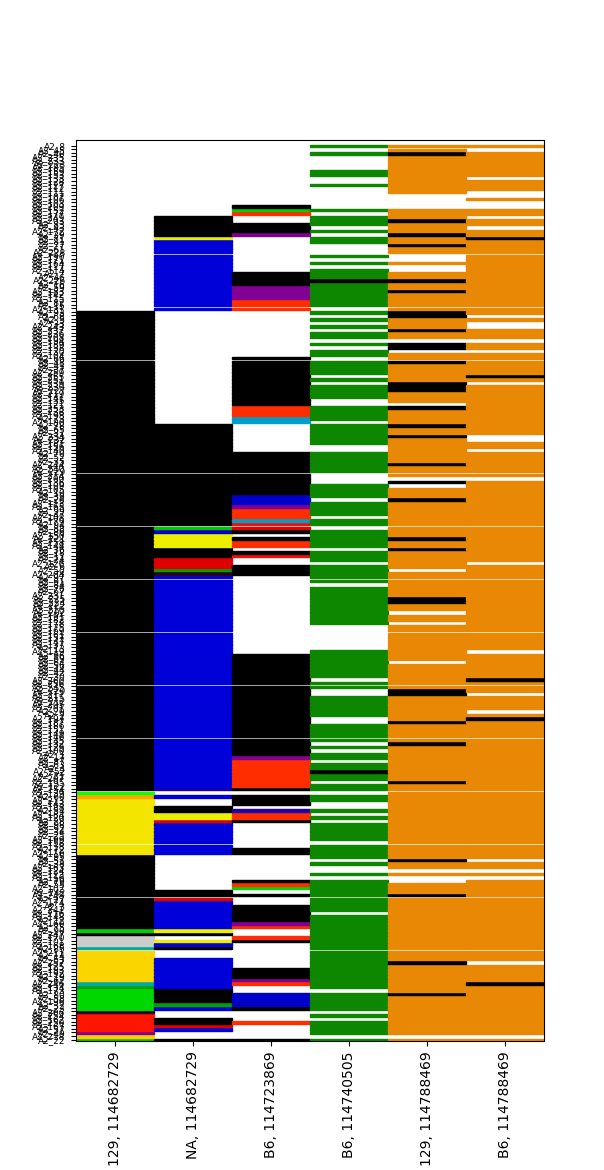

In [28]:
plotHeatmap(selectionAll.loc['C5A9'], (6,10))

<IPython.core.display.Javascript object>


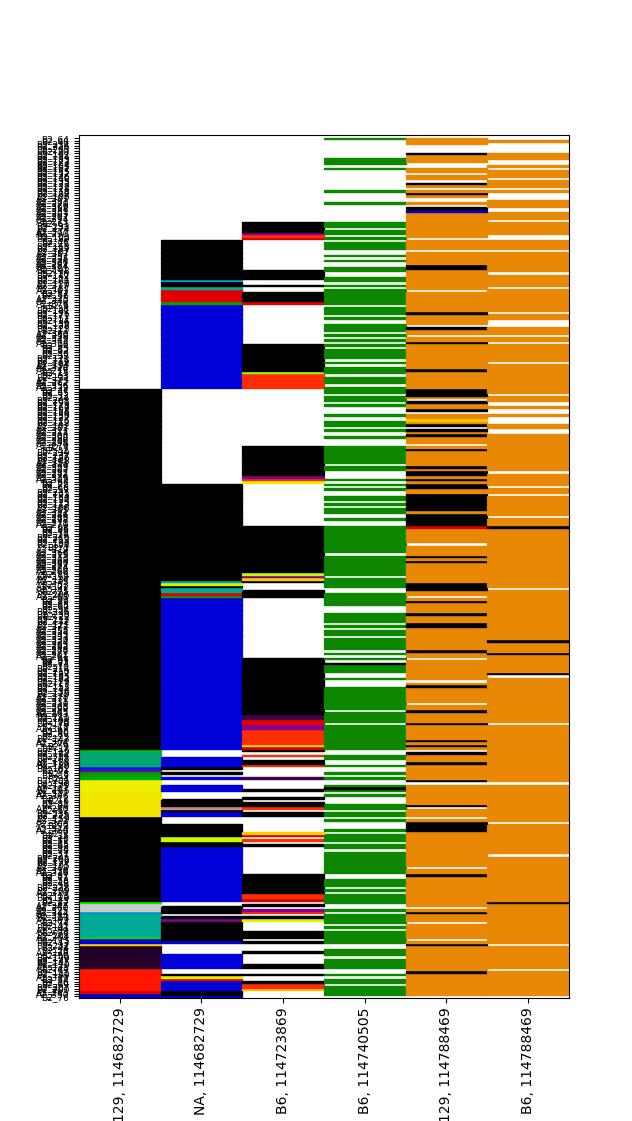

In [29]:
plotHeatmap(selectionAll.loc['C5B10'], (6,10))

<IPython.core.display.Javascript object>


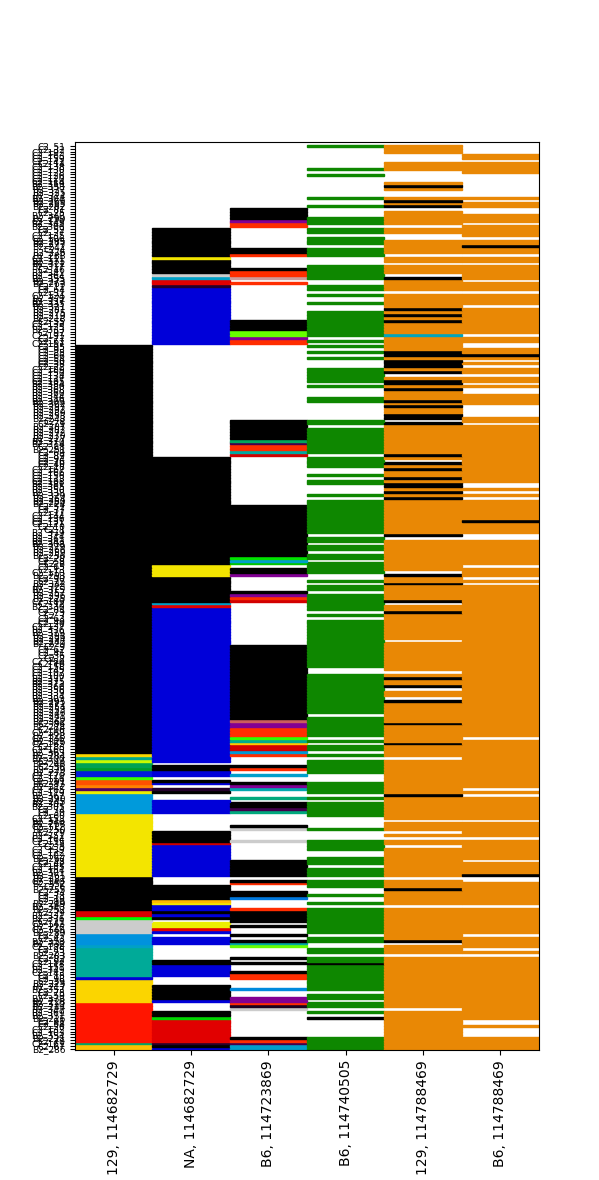

In [30]:
plotHeatmap(selectionAll.loc['C5C6'], (6,10))

<IPython.core.display.Javascript object>


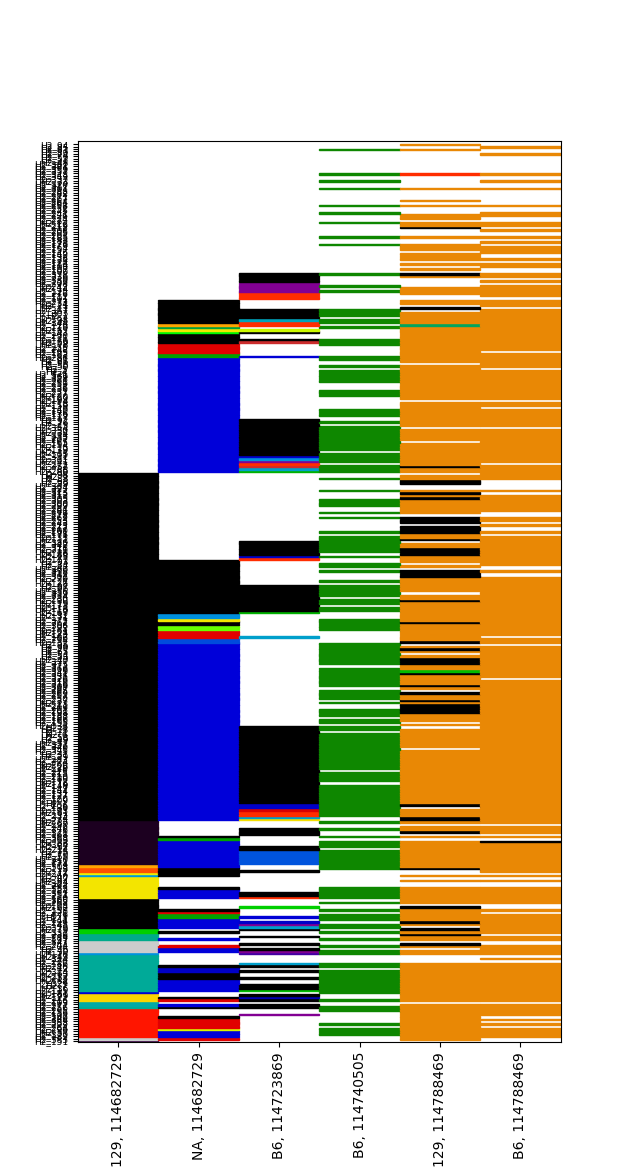

In [31]:
plotHeatmap(selectionAll.loc['C5F10'], (6,10))

<IPython.core.display.Javascript object>


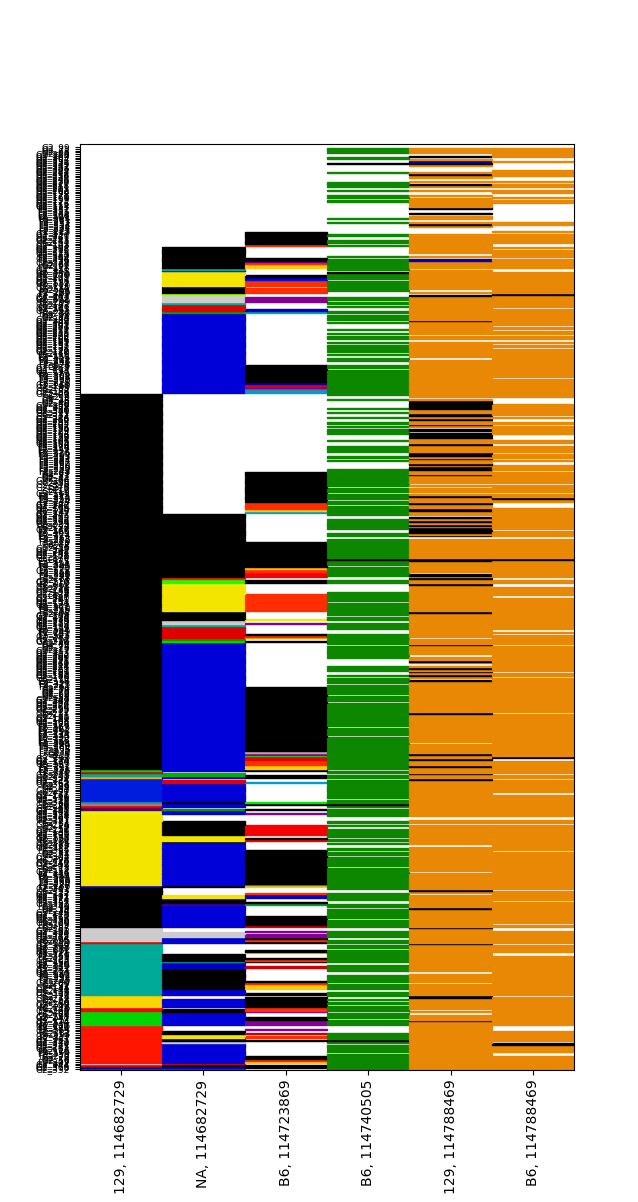

In [32]:
plotHeatmap(selectionAll.loc['C5G7'], (6,10))

<IPython.core.display.Javascript object>


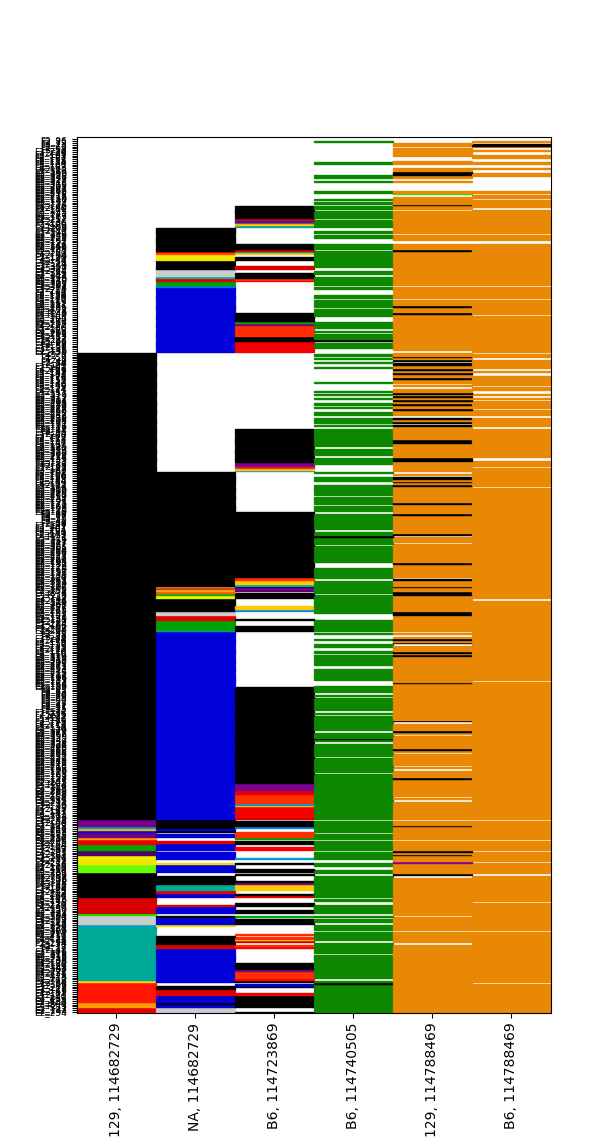

In [33]:
plotHeatmap(selectionAll.loc['C5H11'], (6,10))

<IPython.core.display.Javascript object>


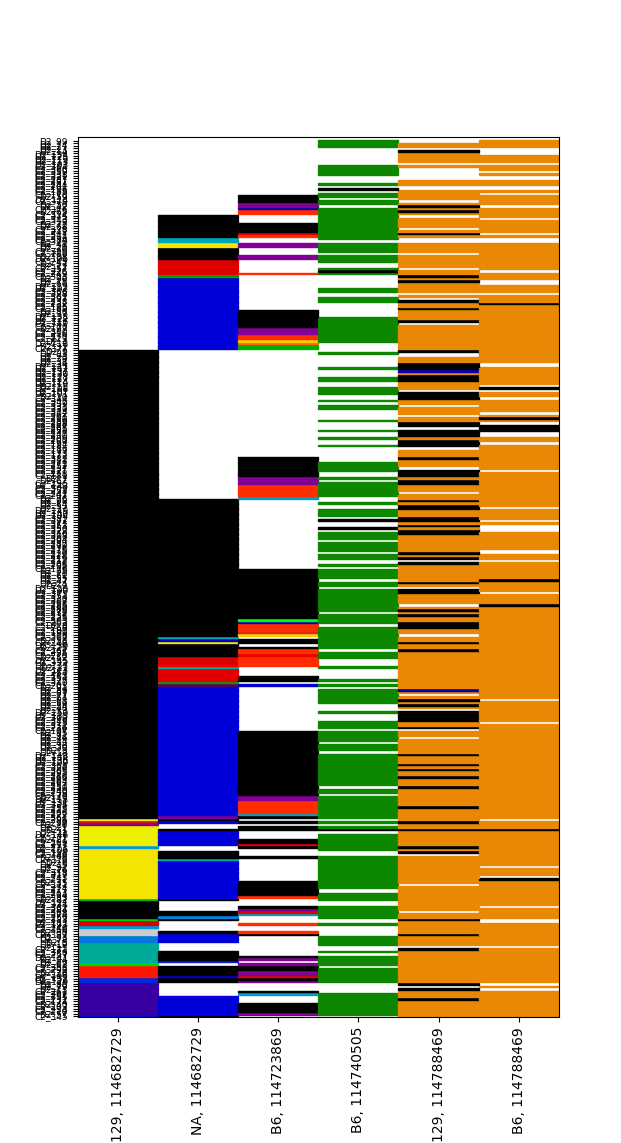

In [34]:
plotHeatmap(selectionAll.loc['C5H7'], (6,10))

<IPython.core.display.Javascript object>


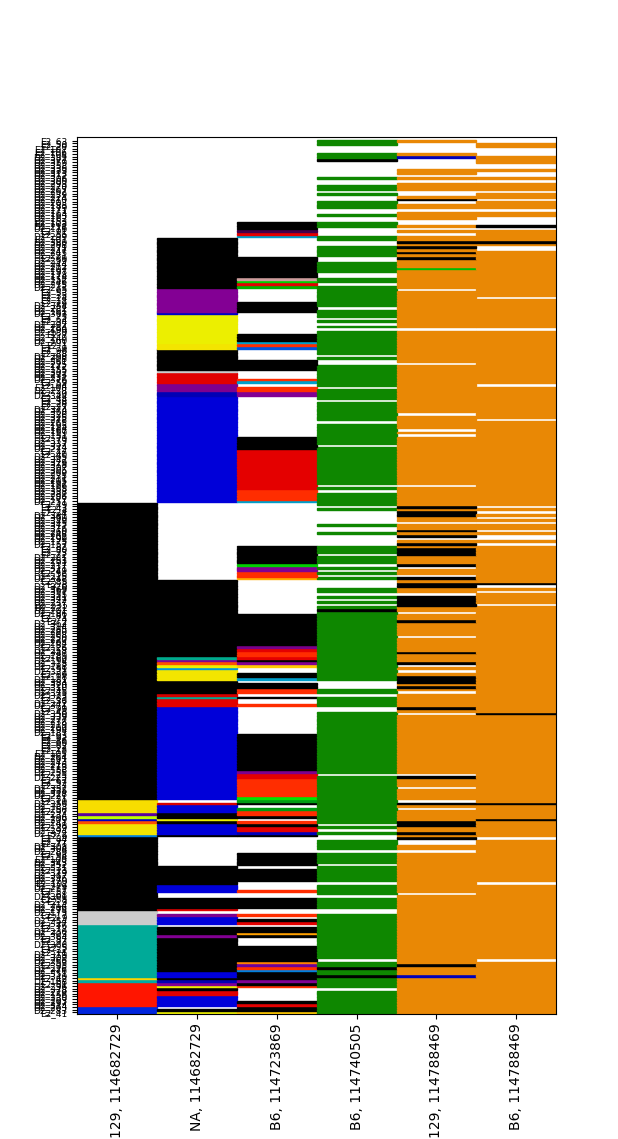

In [35]:
plotHeatmap(selectionAll.loc['C5H9'], (6,10))

Build trees

<IPython.core.display.Javascript object>


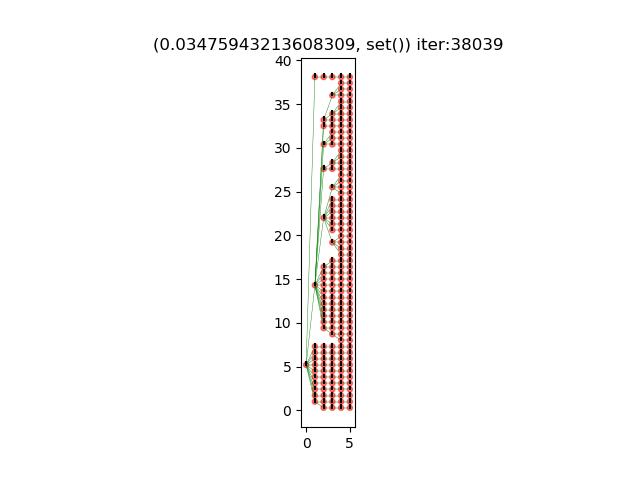

<IPython.core.display.Javascript object>


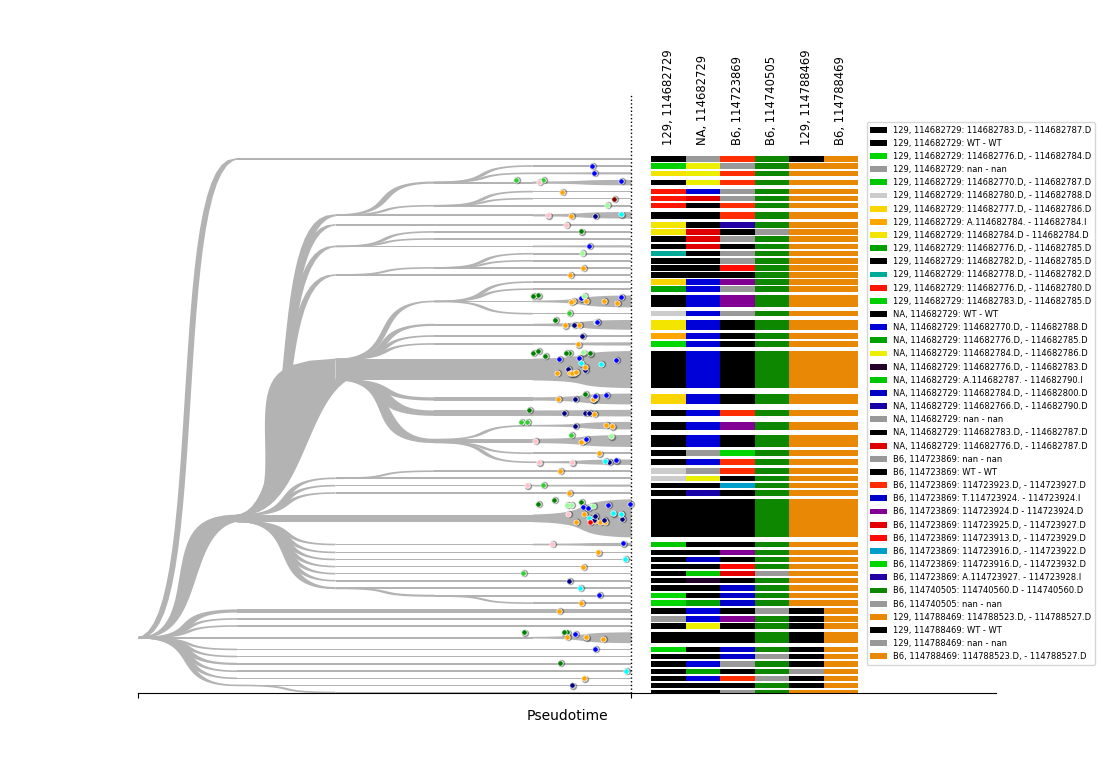

In [36]:
makeTree('C5A9')

<IPython.core.display.Javascript object>


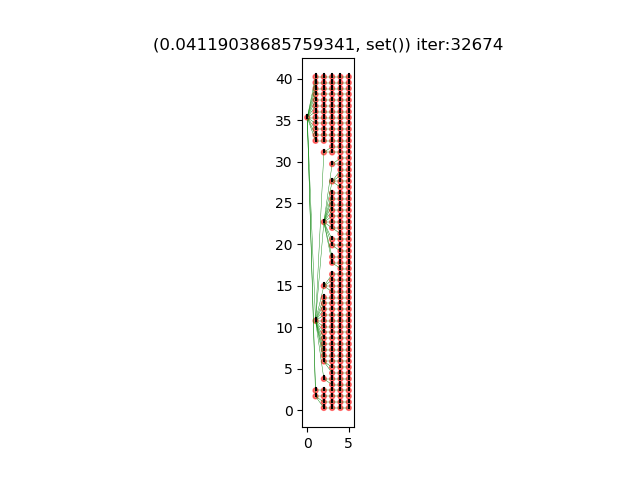

<IPython.core.display.Javascript object>


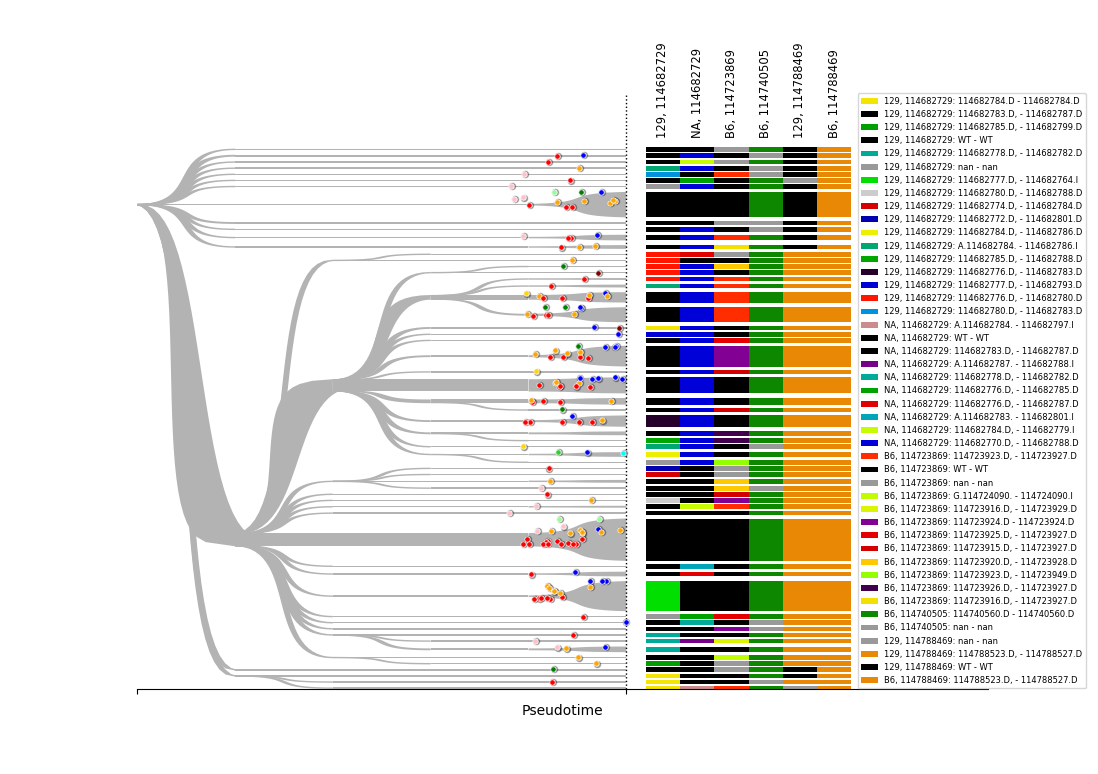

In [37]:
makeTree('C5B10')

<IPython.core.display.Javascript object>


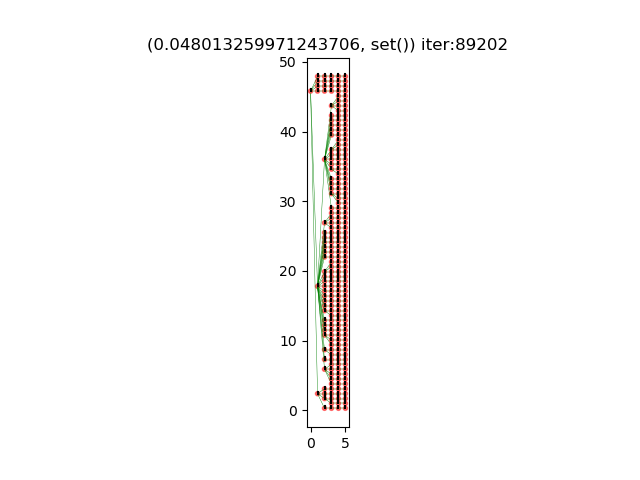

<IPython.core.display.Javascript object>


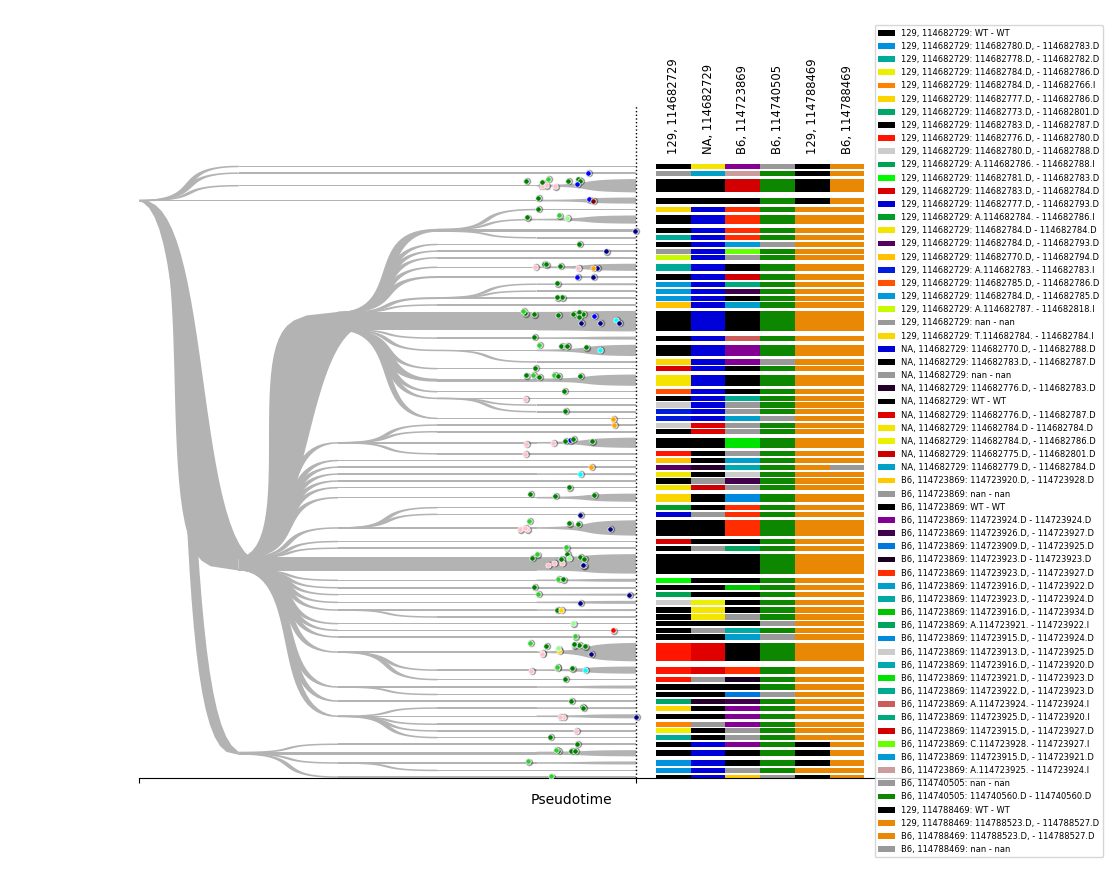

In [38]:
makeTree('C5C6')

<IPython.core.display.Javascript object>


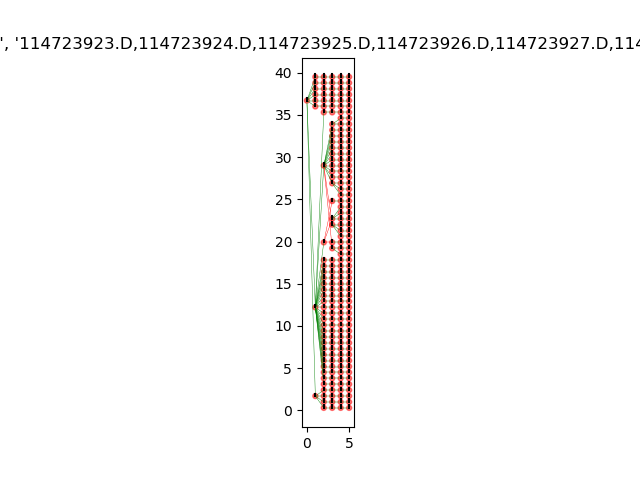

<IPython.core.display.Javascript object>


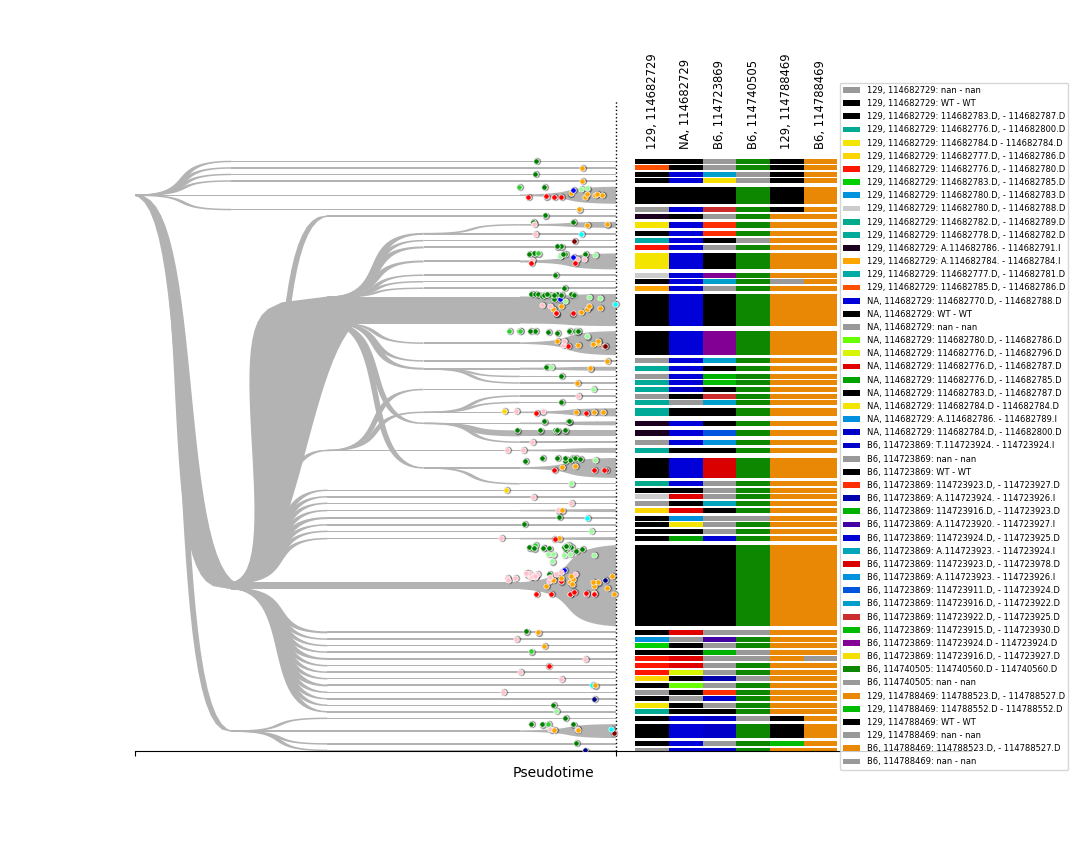

In [39]:
makeTree('C5F10') 

<IPython.core.display.Javascript object>


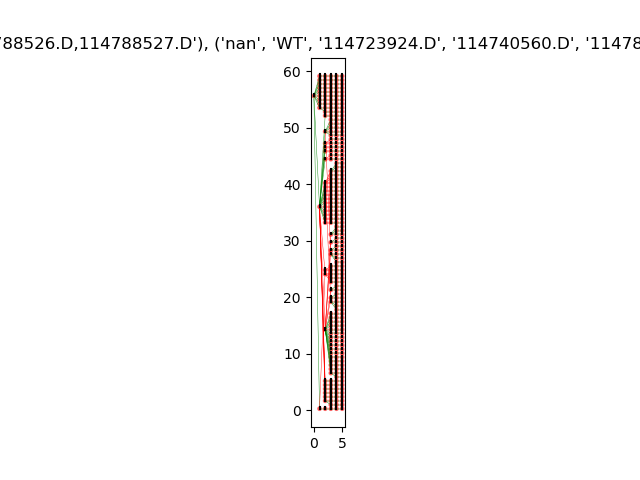

<IPython.core.display.Javascript object>


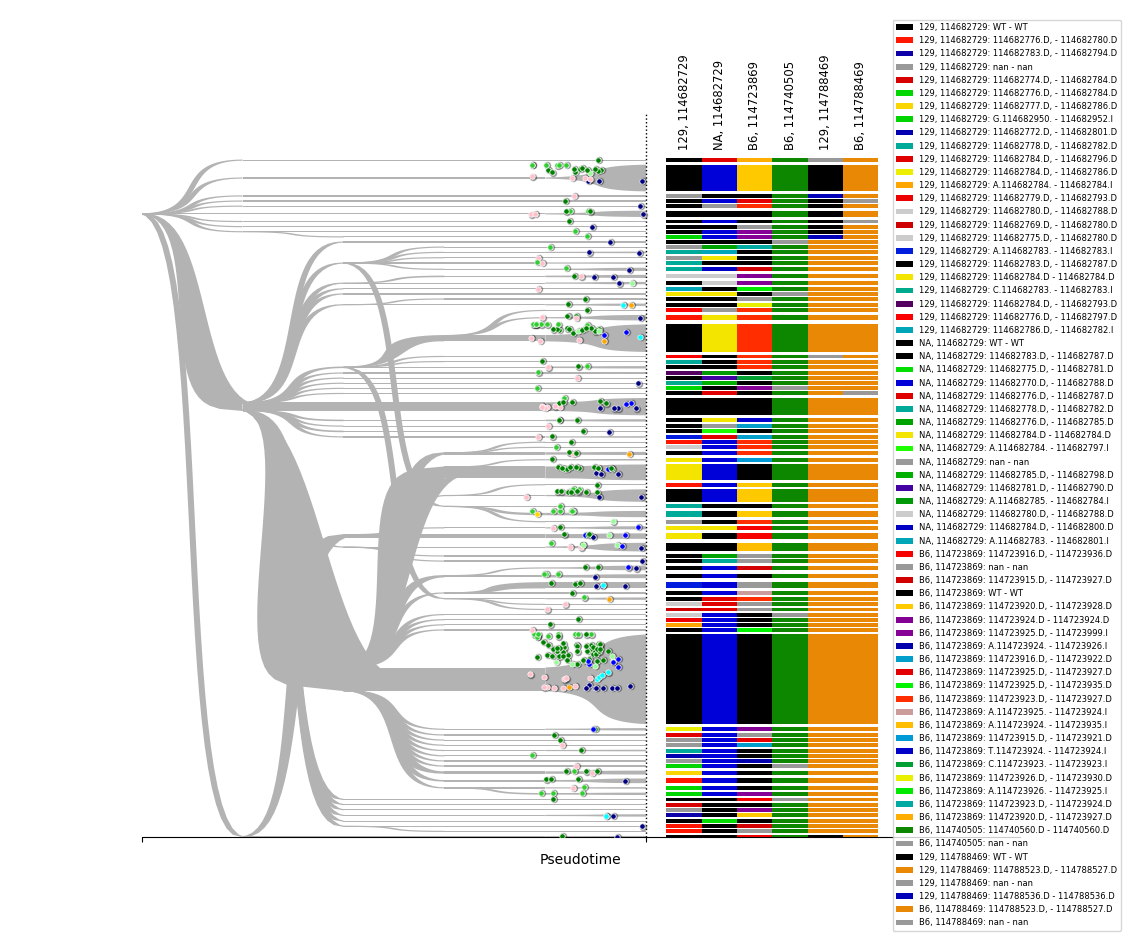

In [40]:
makeTree('C5G7')

<IPython.core.display.Javascript object>


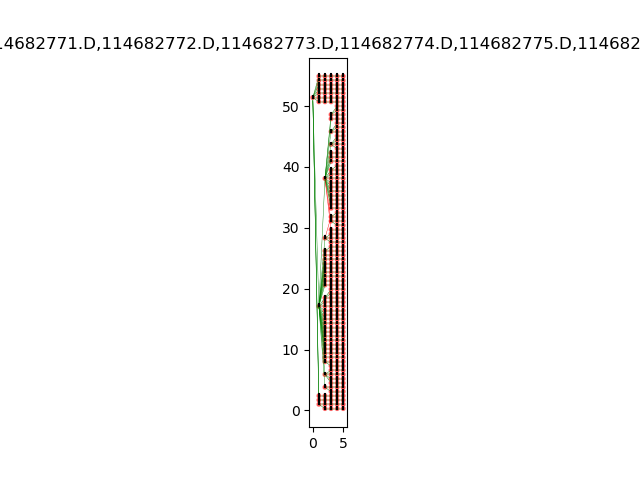

<IPython.core.display.Javascript object>


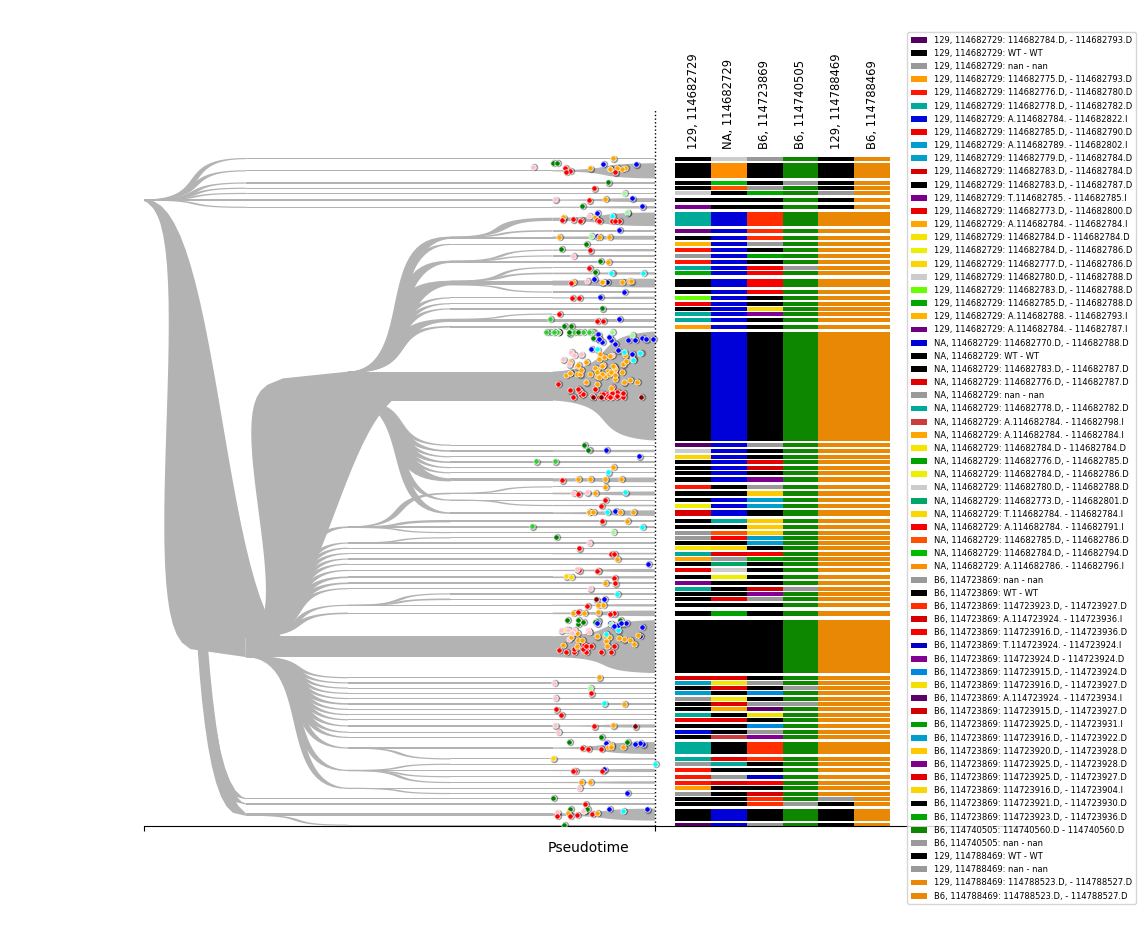

In [41]:
makeTree('C5H11')

<IPython.core.display.Javascript object>


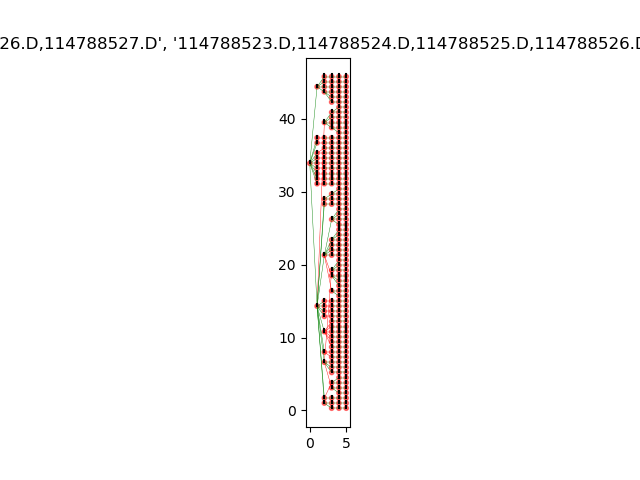

<IPython.core.display.Javascript object>


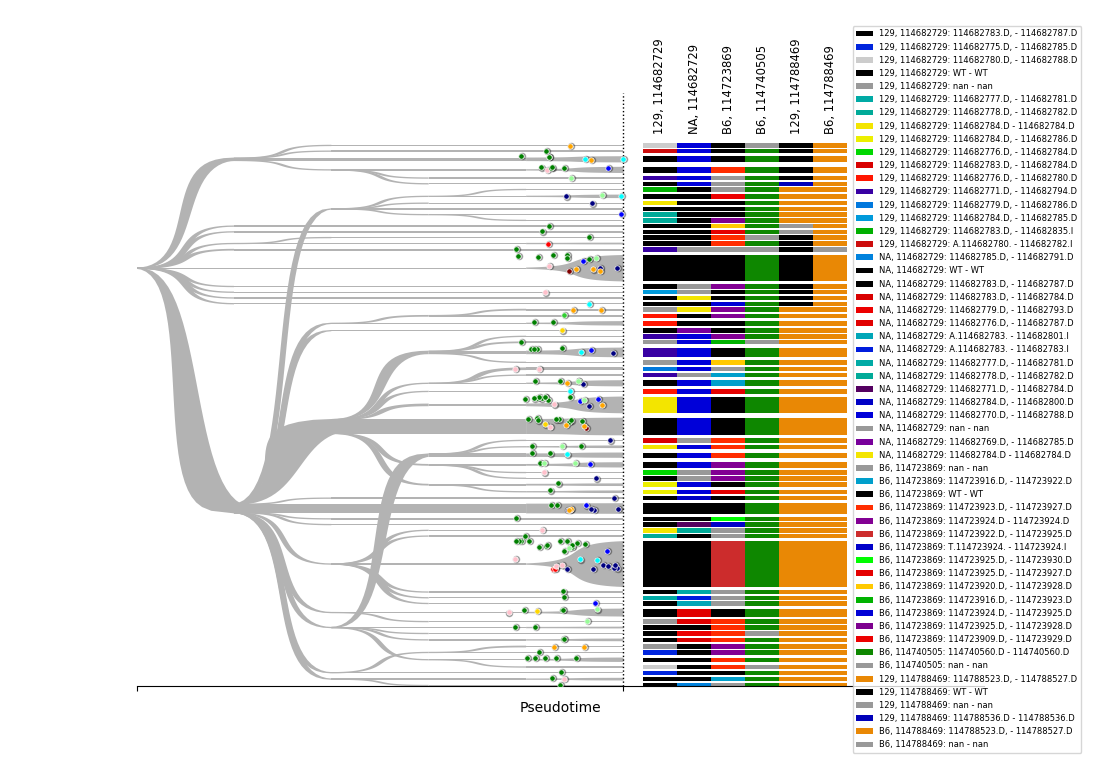

In [42]:
makeTree('C5H7')

<IPython.core.display.Javascript object>


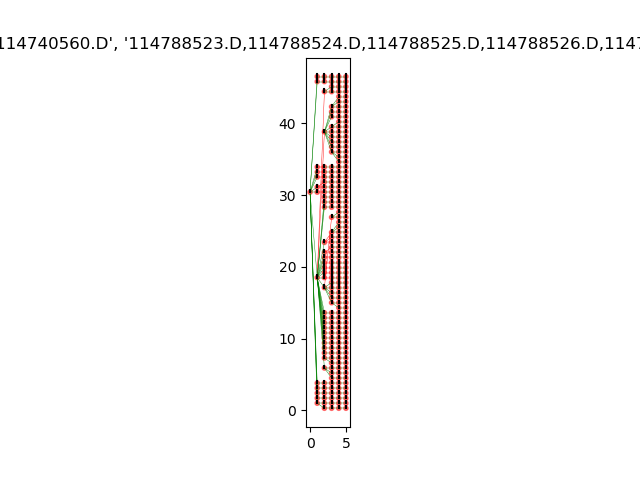

<IPython.core.display.Javascript object>


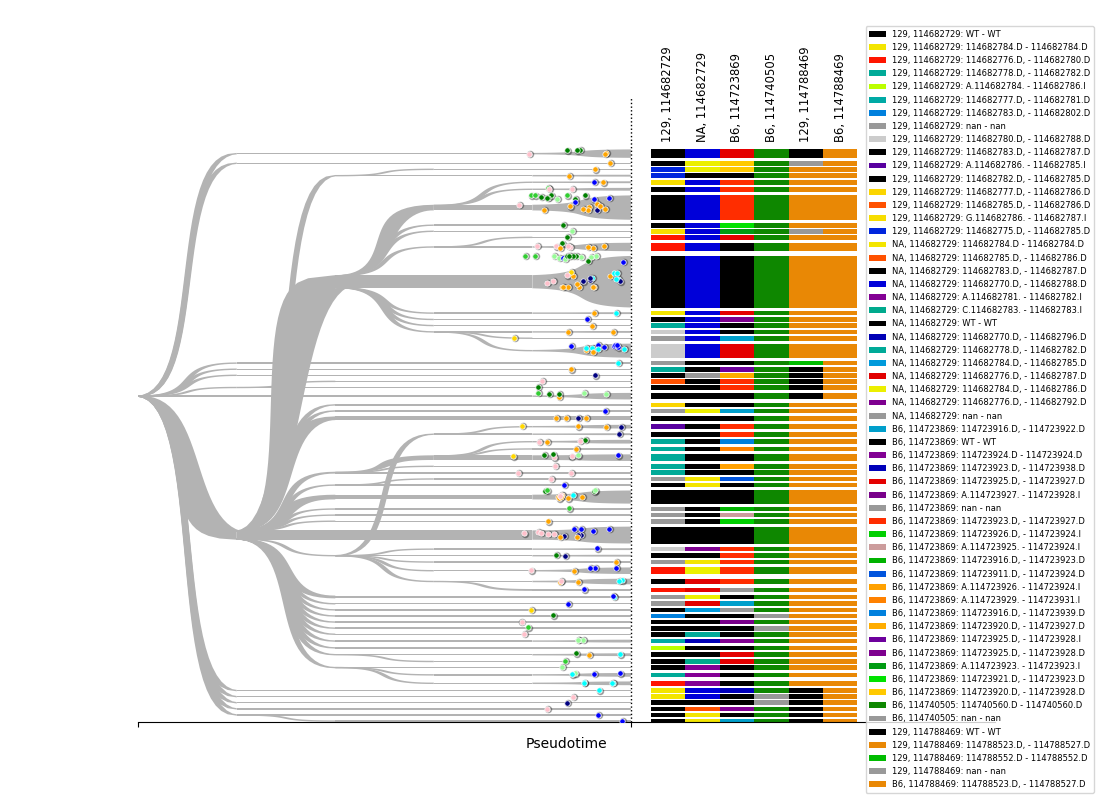

In [43]:
makeTree('C5H9')

In [ ]:
makeTree('C5F10', transcriptomeColours='germlayer_colors', showAllPlots = False)